

# Visualizing Networks and Why You Shouldn't

We've drawn networks several times in this course so far. Here's one of our favorite running examples, the Karate Club graph. Let's compare two ways to draw this network. On the left, we've drawn the graph by assigning every node to a location in the unit square $[0,1]^2$ uniformly at random. On the right, we have used the default layout algorithm in NetworkX, which is invoked automatically when we call `nx.draw`.

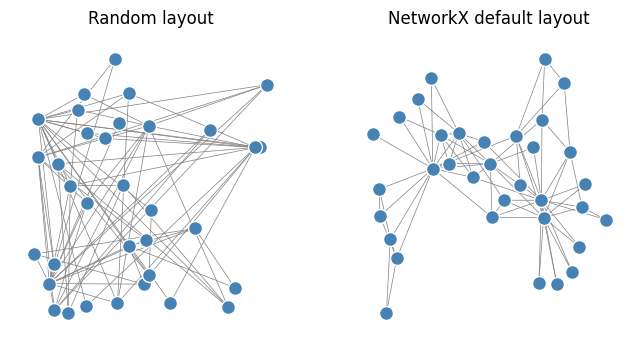

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

fig, ax = plt.subplots(1, 2, figsize = (8, 4))

def unweight(G):
    for source, target in G.edges():
        G[source][target]['weight'] = 1
    return G

G = unweight(nx.karate_club_graph())

draw_kwargs = {"node_color": "steelblue", "node_size": 100, "edge_color": "grey", "edgecolors" : "white", "width": 0.5}

nx.draw(G, ax = ax[1], **draw_kwargs)

ax[1].set_title("NetworkX default layout")

def random_layout(G):
    return np.random.rand(G.number_of_nodes(), 2)

random_layout(G)

nx.draw(G, pos = random_layout(G), ax = ax[0], **draw_kwargs)
title = ax[0].set_title("Random layout")

Which of these drawings look better to you? Which do you feel better helps you understand the structure of the graph?

[![](https://www.data-imaginist.com/assets/img/edge_meme_wide.jpg) *Image credit: [Thomas Lin Pedersen](https://www.data-imaginist.com/posts/2017-02-16-ggraph-introduction-edges/)*]{.column-margin}


## Network Drawing as Network Embedding

While there are many aspects of network drawing (colors, shapes, etc), we'll focus in these notes on one of the most fundamental ones: where should the nodes be placed? Mathematically, placing the nodes in a graph is equivalent to the following task:

> To each node $i \in N$, assign a vector $\mathbf{x}_i \in \mathbb{R}^d$.

If we collect all the nodes together, we aim to find a *matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$, where $n$ is the number of nodes in the graph, such that the $i$th row of $\mathbf{X}$ is the vector $\mathbf{x}_i$ assigned to node $i$.

For drawing on a computer screen or chalkboard, $d = 2$. The general task of placing nodes in Euclidean space is often called *graph embedding* (or even more specifically *node embedding*), and has applications in deep learning for much higher values of $d$.

In this set of notes, we'll motivate and implement two algorithms for performing the embedding task. We'll then discuss some of the significant limitations associated with drawing networks as points connected by line segments, and consider some alternatives.

## Spectral Embedding

In Section 6.14.2, @newman2018networks gives some heuristic reasons to suggest that our friend the Laplacian matrix might be useful for drawing networks. Specifically, if $\mathbf{x} \mathbb{R}$ is a vector giving the locations of nodes on a 1-d interval, the quadratic form $S(\mathbf{x}) = \mathbf{x}^T\mathbf{L}\mathbf{x}$ defined by the Laplacian matrix $\mathbf{L}$ is proportional to the sum of squared lengths on this interval.
So, we might reasonably expect that minimizing $S(\mathbf{x})$ in some way will give us a drawing of the network in which edges are short.
Since we know that the small eigenvalues of a symmetric matrix are related to the problem of minimizing the quadratic form $S(\mathbf{x})$, this suggests that finding the small eigenvalues of the Laplacian could be a useful way to proceed.
As we've seen before, the Laplacian $\mathbf{L}$ has a 0 eigenvalue with an eigenvector of all 1's, which doesn't help us much.
So, let's consider the *next* smallest eigenvalues.
Since we want to draw the network in 2d, we'll take the two smallest eigenvalues of $\mathbf{L}$, and use their corresponding eigenvectors to give us 2d coordinates for each node.

This algorithm is called *Laplacian spectral embedding*. Formally,

1. Form the Laplacian matrix $\mathbf{L} = \mathbf{D} - \mathbf{A}$.
2. Find the *second* and *third* smallest eigenvalues of the Laplacian.[Recall that, if $G$ is connected, then the very smallest eigenvalue of the Laplacian is always equal to 0 and corresponds to an eigenvector with constant entries.]{.aside}. Let $\mathbf{v}_2$ and $\mathbf{v}_3$ be their corresponding eigenvectors.
3. Position the nodes in $\mathbb{R}^2$ according to the values of these eigenvectors: the first coordinate is given by the entries of $\mathbf{v}_2$, and the second coordinate is given by the entries of $\mathbf{v}_3$.

This elegant algorithm is important enough to be implemented in NetworkX: it's `nx.spectral_layout`. But we can implement a full version (for connected graphs) of it ourselves.

In [11]:
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis = 1))
L = D - A

E = tuple(np.linalg.eig(L)) # columns are eigenvectors

_, i, j = np.argsort(E[0])[:3]

v_1 = E[1][:, i]
v_2 = E[1][:, j]

V = np.vstack([v_1, v_2])

pos = {i: V[:, i] for i in range(G.number_of_nodes())}

How'd we do?

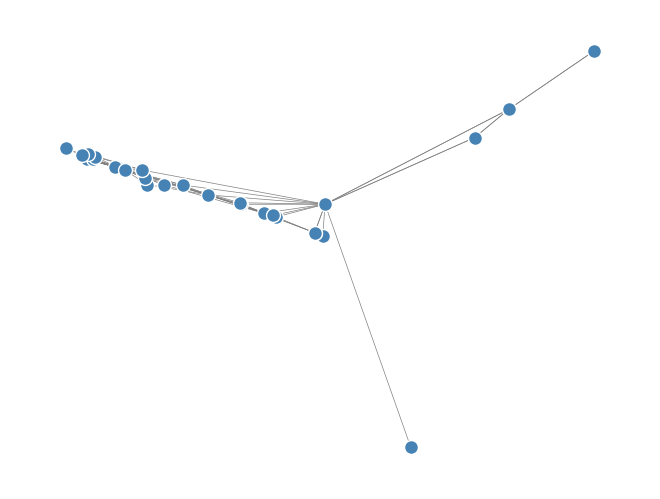

In [12]:
nx.draw(G, pos , **draw_kwargs)

Oh dear, that doesn't look very good at all! This is a good mini-lesson in applied mathematics: sometimes the most elegant solution is outstanding, and sometimes it just doesn't work very well in computational practice.


## Isometry Approximation: The Kamada-Kawai Algorithm

Let's try a better approach: we'll have the distance between nodes in our drawing correspond the distance between nodes in the graph.There are multiple ways to operationalize this idea, but in these notes, we are going to follow the approach of @kamada1989algorithm. Their mathematical version of this motivation is:  

> Choose $\mathbf{X}$ so that the Euclidean distance $d^e_{ij} = \lVert \mathbf{x}_i - \mathbf{x}_j \rVert$ is approximately the same as the graph geodesic distance $d^g_{ij}$ between nodes $i$ and $j$, for all pairs of nodes $(i,j)$.

This approach is an expression of the geometric idea of *isometry*: we are looking to map the nodes from one metric space (the graph) into another metric space (Euclidean space) in a way that approximately preserves distance.

In order to guide our choice of $\mathbf{X}$, we'll define an optimization objective that measures the deviation of the Euclidean distances from the graph geodesic distances: [The set $\binom{N}{2}$ is the set of all pairs of nodes. The notation $\sum_{(i,j) \in \binom{N}{2}}$ is equivalent to the notation $\sum_{i \in N} \sum_{\substack{j \in N \\ j \neq i}}$.]{.aside}

$$
\begin{aligned}
    f(\mathbf{X}, G) &= \sum_{(i,j) \in \binom{N}{2}} \left( d^e_{ij} - d^g_{ij} \right)^2    \\
                     &= \sum_{(i,j) \in \binom{N}{2}} \left( \lVert \mathbf{x}_i - \mathbf{x}_j \rVert - d^g_{ij} \right)^2\;.
\end{aligned}
$${#eq-energy}

This objective function is also sometimes called an "energy" of the problem. Importantly, this objective function is minimized (at 0) when the Euclidean distances are exactly equal to the graph geodesic distances.
This is not usually possible, and so we'll often need to settle for a nonzero value of $f(\mathbf{X}, G)$.

Let's implement a function that computes the energy, given a matrix of distances $\mathbf{D}$ and a matrix of node positions $\mathbf{X}$.

In [23]:
def energy(X, D): #D holds all pairwise distances d_ij
  n = X.shape[0]
  e = 1/2 * np.sum([(np.linalg.norm(X[i]-X[j]) - D[i,j])**2 for i in range(n) for j in range(n)])
  return e

There are multiple ways to solve the problem of minimizing the energy. In our approach, we are going to use a greedy algorithm in which we minimize the energy with respect to the position of one node at a time. To this end, it's also helpful to define a *partial energy* which measures the contribution of a single node to the total energy. This is the function that we'll actually minimize in our inner loop.

::: {.callout-important}

## Exercise

Give a formula for the partial energy for node $k$: the terms in @eq-energy that depend on node $k$.

:::

With a formula in hand, we can implement: [There is some redundancy in this function signature: we are passing the current position $\mathbf{x}$ of node $k$, the positions $\mathbf{X}$ of all nodes, the matrix $\mathbf{D}$ of distances, and the index $k$ of node $k$. The reason we are doing this is so that the minimization function we will soon employ works correctly.]{.aside}

In [24]:
def partial_energy(x, X, D, k):
    return np.sum([(np.linalg.norm(x - X[j]) - D[k, j])**2 for j in range(G.number_of_nodes())])

Now we'll implement an algorithm that attempts to minimize the energy by moving the position of each node, one at a time. We cycle through all the nodes, updating each of them, and then we repeat the process for some specified number of iterations. First, let's visualize how this looks. Then, we'll implement this algorithm ourselves.

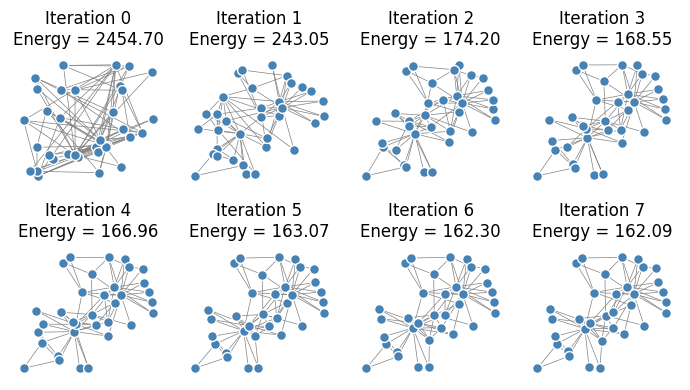

In [25]:
fig, ax = plt.subplots(2, 4, figsize = (7, 4))

D = nx.floyd_warshall_numpy(G) # matrix of Euclidean distances
X = random_layout(G) # initialization

for i, ax in enumerate(ax.flatten()):
    ax.set_title(f"Iteration {i}\nEnergy = {energy(X, D):.2f}")
    nx.draw(G, pos = {i: X[i] for i in range(G.number_of_nodes())}, ax = ax, node_size = 50, edge_color = "gray", edgecolors = "white", node_color = "steelblue", width = 0.5)
    for k in range(G.number_of_nodes()):
        res = minimize(partial_energy, X[k], args = (X, D, k), method = 'BFGS')
        X[k] = res.x
plt.tight_layout()

Note that the energy very quickly shrinks after the first iteration. The structure of the visualization is resolved fairly clearly after just a small number of iterations.

Ok, let's implement a complete function.

In [27]:
def optimization_layout(G, n_iter = 100, energy_fun = energy, partial_energy_fun = partial_energy):
    D = nx.floyd_warshall_numpy(G) # gives you the matrix of graph distances
    X = random_layout(G)

    for _ in range(n_iter):
      print(f"Current energy : {energy(X, D)}")

      for k in range(G.number_of_nodes()):
        res = minimize(partial_energy_fun, X[k], args = (X, D, k), method = 'BFGS')
        X[k] = res.x
    return X

Let's try it out:

Current energy : 2515.4669697605245
Current energy : 245.81290391343055
Current energy : 167.2433746567229
Current energy : 164.14035663475272
Current energy : 163.60951646741802
Current energy : 162.82407516512595
Current energy : 162.61615755980125
Current energy : 162.5796774921895
Current energy : 162.5722352492994
Current energy : 162.5695876379633


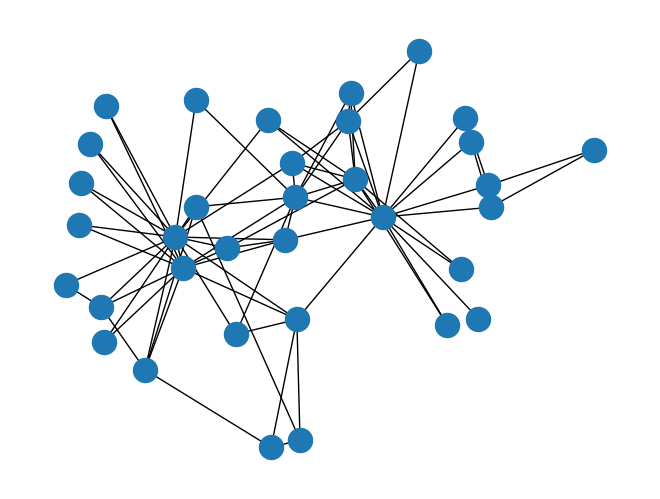

In [29]:
X = optimization_layout(G, n_iter=10)
nx.draw(G, pos = {i: X[i] for i in range(G.number_of_nodes())})

Our result looks pretty reasonable. Nodes that "should" be close to each other do indeed appear to be drawn close together in the graph.

The results are not always reliable; if we check the Les Miserables graph, we might argue that a lot of the nodes in the dense center of the graph are a little too squished together:

Current energy : 73044.40869612078
Current energy : 4850.7457746704495
Current energy : 3440.5808466189537
Current energy : 3090.7031590195074
Current energy : 3080.11124070432
Current energy : 3078.547187064505
Current energy : 3078.011115704106
Current energy : 3077.655689287217
Current energy : 3077.5426987834626
Current energy : 3077.180733029967


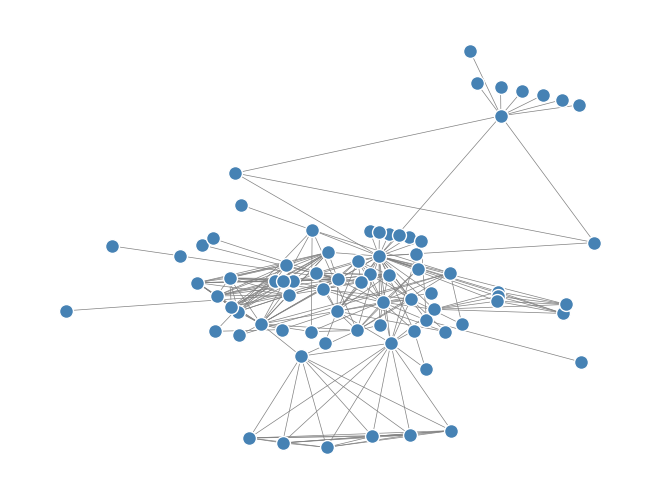

In [30]:
G = nx.convert_node_labels_to_integers(nx.les_miserables_graph())
X = optimization_layout(G, n_iter = 10)
nx.draw(G, pos = {i: X[i] for i in range(G.number_of_nodes())}, **draw_kwargs)

### An Adjustment

We can compensate for this by weighting pairs of nodes differently. In the final form of the Kamada-Kawai algorithm, we modify the objective function by incorporating an inverse-square distance weighting. The modified objective function is

$$
\begin{aligned}
    f(\mathbf{X}, G)  &= \sum_{(i,j) \in \binom{N}{2}} \frac{1}{\left(d^g_{ij}\right)^2}\left( \lVert \mathbf{x}_i - \mathbf{x}_j \rVert - d^g_{ij} \right)^2\;.
\end{aligned}
$$

The implementation here is very similar to our unweighted implementation: we just need to divide by $d_{ij}^2$.

In [31]:
def energy_weighted(X, D):
    n = X.shape[0]
    return np.sum([(np.linalg.norm(X[i] - X[j]) - D[i, j])**2/D[i, j]**2 for i in range(n) for j in range(n) if j != i])

def partial_energy_weighted(x, X, D, k):
    return np.sum([(np.linalg.norm(x - X[j]) - D[k, j])**2 / D[k,j]**2 for j in range(G.number_of_nodes()) if j != k])

This version resolves the nodes in the dense core of the network somewhat more cleanly.

::: {.column-margin}

A few caveats related to this algorithm:

1. The energy function is nonconvex, and so in general it is possible for the optimization routine to get stuck at a suboptimal local minimum.
2. Any rotation or reflection of the node positions $\mathbf{X}$ yields a new layout with the same energy.
3. The computation of the complete matrix of pairwise geodesic distances is in general quite expensive on networks of even moderate size.

:::

There are many other ways to draw networks, several of which are implemented as built-in methods in NetworkX. See the [documentation](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) for various other possibilities.


## Why You Shouldn't Draw Networks

Making attractive visualizations of large networks is a very fun and satisfying thing to do, and some software packages like [Gephi](https://gephi.org/) are specifically designed for this task. We encourage you to put network visualizations on your phone wallpaper, t-shirts, posters, websites, etc. [Indeed, we put a particularly appealing network visualization by HZB's students on our [landing page](index.qmd), and PSC  made a graph visualization as the image background of [his website](https://www.philchodrow.prof/).]{.aside}

So, what do we mean when we say that you shouldn't draw networks? In general, it's very difficult to extract reliable structural insights about networks by eye. This means that the one place drawings of networks *usually* don't belong is in scientific papers. It's just too easy for the eye to be drawn to structural features that may or may not actually be present in the data. For this reason, node-edge visualizations of large networks have been called names like "[ridiculograms](https://petterhol.me/2018/05/28/ridiculograms-a-ridiculous-dialogue/)" and [hairballs](https://skewed.de/tiago/posts/hairball/) by prominent network scientists.

### What You Should Do Instead

The right way to visualize the structure of your network is *very* context-dependent, and there are many, many possibilities. Here we'll point out just one: the adjacency matrix. This is a common strategy for visualizing networks that separate into one or more distinct clusters, sometimes also called "communities." For example, simply inspecting the adjacency matrix of the Les Miserables graph can reveal a lot about its structure:

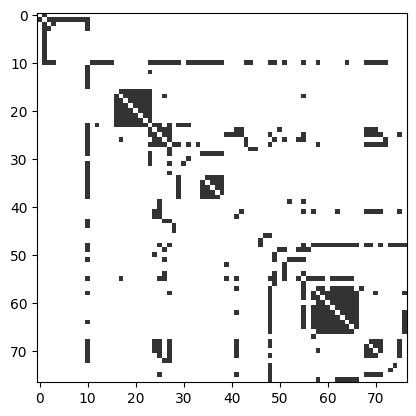

In [32]:
G = nx.les_miserables_graph()
G = unweight(G)
G = nx.convert_node_labels_to_integers(G)
A = nx.to_numpy_array(G)
plt.imshow(A, cmap = "Greys", vmax = 1.2)

The adjacency matrix allows to easily see the presence of dense clusters (indeed, several cliques) in the graph, as well as a few nodes who seem to interact with almost all of the other ones.

In this case, the adjacency matrix was already sorted by node in a way that made the structure clear. In more complicated cases, we may need to use a *community detection algorithm* to find a way to sort the nodes that reveals useful structure. This is a complicated (and thorny) topic which we'll touch on later in this course.

## References